In [11]:
import sklearn
import time
import pandas as pd
from matplotlib import pyplot
from numpy import mean
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split, RepeatedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, LabelEncoder
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2  # Choose an appropriate scoring function for your data
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


import numpy as np


In [ ]:

df_train_orig = pd.read_csv('train.csv')
df_test_orig = pd.read_csv('test.csv')

print(df_train_orig.shape)
print(df_test_orig.shape)

df_train = df_train_orig.copy()
df_test = df_test_orig.copy()
target_col = 'price_doc'
row_id_col = 'row ID'


In [2]:

# Label encode the 'sub_area' column
label_encoder = LabelEncoder()
df_train['sub_area'] = label_encoder.fit_transform(df_train['sub_area'])
df_test['sub_area'] = label_encoder.transform(df_test['sub_area'])

X_train = pd.get_dummies(df_train.drop(columns=[target_col]), drop_first=True)
X_test = pd.get_dummies(df_test, drop_first=True)

row_ids = df_test['row ID']
X_test.drop(['row ID'], axis=1, inplace=True)
print(X_train.shape, '\n', X_test.shape)
X = pd.get_dummies(df_train.drop(columns=[target_col]), drop_first=True)
y = df_train[target_col]

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.05, random_state=42)


(181507, 274) 
 (77789, 274)


30124      535
134681    1649
105079    1524
131181     507
28846     1538
          ... 
119879     463
103694    1456
131932     496
146867     618
121958     626
Name: sub_area, Length: 172431, dtype: int64

In [5]:

# Define the decision tree model for feature selection
tree = DecisionTreeRegressor(random_state=42, max_depth=8, min_samples_leaf=5)

# Fit the decision tree model on the data
tree.fit(X_train, y_train)


DecisionTreeRegressor(max_depth=8, min_samples_leaf=5, random_state=42)

In [6]:

# Get feature importances from the decision tree model
feature_importances = tree.feature_importances_

# Get indices of top 50 features based on importance
top_50_indices = feature_importances.argsort()[-50:][::-1]

# Get the corresponding column names
selected_col = X_train.columns[top_50_indices]
selected_col

Index(['mosque_count_500', 'culture_objects_top_25_raion', 'full_sq',
       'cafe_count_5000_price_high', 'cafe_count_3000',
       'culture_objects_top_25_yes', 'cafe_count_3000_price_2500',
       'sport_count_3000', 'sport_count_2000', 'university_km',
       'raion_build_count_with_builddate_info', 'indust_part', 'life_sq',
       'build_count_1971-1995', 'workplaces_km', 'cemetery_km',
       'cafe_count_3000_price_high', 'build_count_1921-1945',
       'cafe_count_2000_price_4000', 'ID_railroad_station_avto',
       'additional_education_raion', 'preschool_km',
       'cafe_count_2000_na_price', '7_14_male', 'young_all',
       'cafe_count_500_price_high', 'sadovoe_km', 'cafe_count_1500_na_price',
       'church_count_1500', 'build_count_after_1995', 'railroad_km',
       'shopping_centers_km', 'trc_count_1000', 'hospice_morgue_km',
       'exhibition_km', 'market_count_5000', 'mosque_count_2000',
       'power_transmission_line_km', 'cafe_sum_3000_min_price_avg',
       '16_29_

In [9]:

# Filter the training and validation data with the selected features
X_train_selected = X_train[selected_col]
X_val_selected = X_val[selected_col]
print(X_train_selected.shape, X_val_selected.shape)
# Scale the selected features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_val_scaled = scaler.transform(X_val_selected)

# Train the linear regression model on the selected features
model = LinearRegression()
model.fit(X_train_scaled, y_train)


(172431, 50) (9076, 50)


LinearRegression()

In [12]:

# Evaluate the model
predictions = model.predict(X_val_scaled)
rmse = np.sqrt(mean_squared_error(y_val, predictions))
print("RMSE with selected features:", rmse)

# Filter the test data with the selected features
X_test_selected = X_test[selected_col]

# Scale the selected features
X_test_scaled = scaler.transform(X_test_selected)  # Assuming 'scaler' is the trained StandardScaler

# Make predictions on the test data
test_predictions = model.predict(X_test_scaled)

# Create a DataFrame with 'row ID' and predictions
result_df = pd.DataFrame({'row ID': row_ids, 'price_doc': test_predictions})

# Save the results to a CSV file
result_df.to_csv('predictions3.csv', index=False)


RMSE with selected features: 13874738.00877532


In [41]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Load the training and test data
df_train_orig = pd.read_csv('train.csv')
df_test_orig = pd.read_csv('test.csv')

# Make a copy of the original data
df_train = df_train_orig.copy()
df_test = df_test_orig.copy()
target_col = 'price_doc'
row_id_col = 'row ID'

# Label encode the 'sub_area' column
label_encoder = LabelEncoder()
df_train['sub_area'] = label_encoder.fit_transform(df_train['sub_area'])
df_test['sub_area'] = label_encoder.transform(df_test['sub_area'])

# Create dummy variables for categorical features
X_train = pd.get_dummies(df_train.drop(columns=[target_col]), drop_first=True)
X_test = pd.get_dummies(df_test, drop_first=True)

# Extract the 'row ID' column for later use and remove it from X_test
row_ids = df_test['row ID']
X_test.drop(['row ID'], axis=1, inplace=True)

# Extract the target variable and create a feature matrix
X = pd.get_dummies(df_train.drop(columns=[target_col]), drop_first=True)
y = df_train[target_col]

# Scale the values
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_test = scaler.transform(X_test)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.05, random_state=42)

# Compute variances of features
variances = np.var(X_train, axis=0)

# Iterate over different values of k
for k in range(15, 271, 15):
    # Get the indices of the top k features with the highest variances
    top_k_indices = np.argsort(variances)[-k:]

    # Select the top k features
    X_train_selected = X_train[:, top_k_indices]
    X_val_selected = X_val[:, top_k_indices]

    print("Number of features selected:", X_train_selected.shape[1])

    # Train the linear regression model on the selected features
    model = LinearRegression()
    model.fit(X_train_selected, y_train)

    # Evaluate the model
    predictions = model.predict(X_val_selected)
    rmse = np.sqrt(mean_squared_error(y_val, predictions))
    print(f"RMSE with top {k} variance selected features:", rmse)

    # Transform the test data using the same feature selection
    X_test_selected = X_test[:, top_k_indices]

    # Make predictions on the test data
    test_predictions = model.predict(X_test_selected)

    # Create a DataFrame with 'row ID' and predictions
    result_df = pd.DataFrame({'row ID': row_ids, 'price_doc': test_predictions})

    # Save the results to a CSV file
    result_df.to_csv(f'predictions_top_{k}_variance_features.csv', index=False)


Number of features selected: 15
RMSE with top 15 variance selected features: 14567619.343945056
Number of features selected: 30
RMSE with top 30 variance selected features: 13951382.398785004
Number of features selected: 45
RMSE with top 45 variance selected features: 13753493.101001613
Number of features selected: 60
RMSE with top 60 variance selected features: 13632182.531351903
Number of features selected: 75
RMSE with top 75 variance selected features: 13573313.71213994
Number of features selected: 90
RMSE with top 90 variance selected features: 13520218.5490231
Number of features selected: 105
RMSE with top 105 variance selected features: 13489149.853239339
Number of features selected: 120
RMSE with top 120 variance selected features: 13472756.303250194
Number of features selected: 135
RMSE with top 135 variance selected features: 13455569.370513437
Number of features selected: 150
RMSE with top 150 variance selected features: 13444299.5223306
Number of features selected: 165
RMSE

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

# Load the training and test data
df_train_orig = pd.read_csv('train.csv')
df_test_orig = pd.read_csv('test.csv')

# Make a copy of the original data
df_train = df_train_orig.copy()
df_test = df_test_orig.copy()
target_col = 'price_doc'
row_id_col = 'row ID'

# Label encode the 'sub_area' column
label_encoder = LabelEncoder()
df_train['sub_area'] = label_encoder.fit_transform(df_train['sub_area'])
df_test['sub_area'] = label_encoder.transform(df_test['sub_area'])

# Create dummy variables for categorical features
X_train = pd.get_dummies(df_train.drop(columns=[target_col]), drop_first=True)
X_test = pd.get_dummies(df_test, drop_first=True)


In [31]:
X_train.shape

(181507, 274)

In [2]:

# Extract the 'row ID' column for later use and remove it from X_test
row_ids = df_test['row ID']
X_test.drop(['row ID'], axis=1, inplace=True)

# Extract the target variable
y = df_train[target_col]

# Scale the values
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y, test_size=0.05, random_state=42)


In [3]:
# Define a list of alpha values
alpha_values = [0.1, 0.5, 1.0, 2.0, 5.0]

# Iterate over the alpha values
for alpha in alpha_values:
    # Train the Lasso regression model
    lasso_model = Lasso(alpha=alpha)
    lasso_model.fit(X_train, y_train)

    # Evaluate the model
    predictions = lasso_model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, predictions))
    print(f"RMSE with Lasso regression (alpha={alpha}):", rmse)

    # Make predictions on the test data
    # test_predictions = lasso_model.predict(X_test)

    # Create a DataFrame with 'row ID' and predictions
    # result_df = pd.DataFrame({'row ID': row_ids, 'price_doc': test_predictions})

    # Save the results to a CSV file
    # result_df.to_csv(f'lasso_regression_predictions_alpha_{alpha}.csv', index=False)


/opt/homebrew/Caskroom/miniforge/base/envs/imlenv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.530e+19, tolerance: 8.221e+15
  model = cd_fast.enet_coordinate_descent(


RMSE with Lasso regression (alpha=0.1): 13385523.674609609


/opt/homebrew/Caskroom/miniforge/base/envs/imlenv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.530e+19, tolerance: 8.221e+15
  model = cd_fast.enet_coordinate_descent(


RMSE with Lasso regression (alpha=0.5): 13385522.30703979


/opt/homebrew/Caskroom/miniforge/base/envs/imlenv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.530e+19, tolerance: 8.221e+15
  model = cd_fast.enet_coordinate_descent(


RMSE with Lasso regression (alpha=1.0): 13385520.598313207


/opt/homebrew/Caskroom/miniforge/base/envs/imlenv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.530e+19, tolerance: 8.221e+15
  model = cd_fast.enet_coordinate_descent(


RMSE with Lasso regression (alpha=2.0): 13385517.179770539


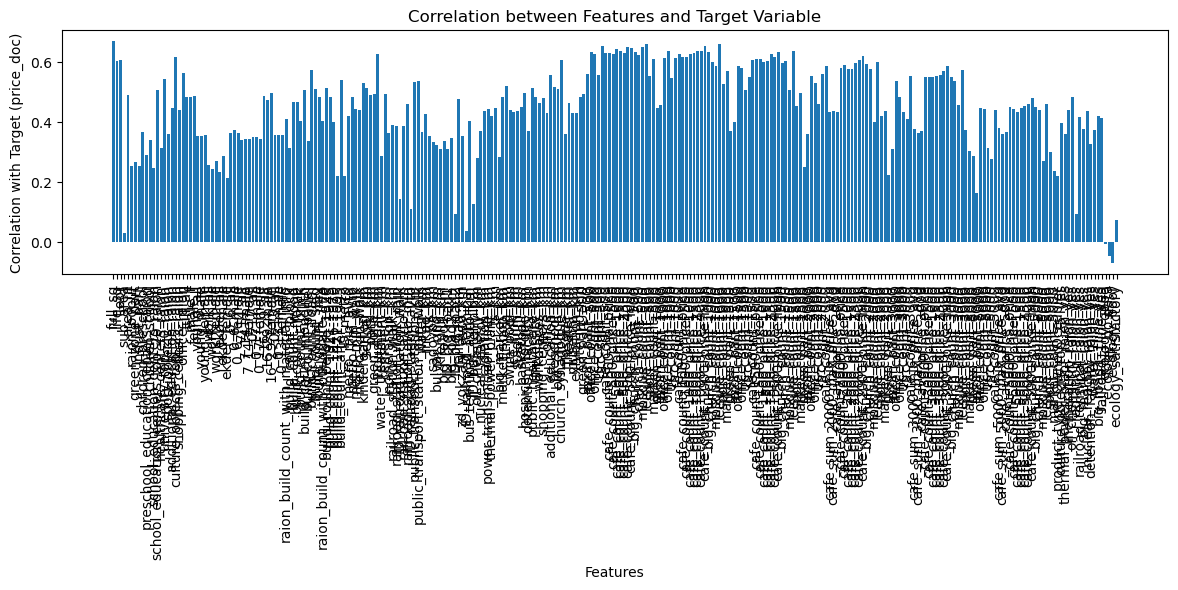

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load the training and test data
df_train_orig = pd.read_csv('train.csv')
df_test_orig = pd.read_csv('test.csv')

# Make a copy of the original data
df_train = df_train_orig.copy()
df_test = df_test_orig.copy()
target_col = 'price_doc'
row_id_col = 'row ID'

# Label encode the 'sub_area' column
label_encoder = LabelEncoder()
df_train['sub_area'] = label_encoder.fit_transform(df_train['sub_area'])
df_test['sub_area'] = label_encoder.transform(df_test['sub_area'])

# Create dummy variables for categorical features
X_train = pd.get_dummies(df_train.drop(columns=[target_col]), drop_first=True)
X_train_2 = X_train.copy()
X_test = pd.get_dummies(df_test, drop_first=True)

# Extract the target variable
y = df_train[target_col]

# Scale the values
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y, test_size=0.05, random_state=42)

# Calculate the correlation matrix
correlation_matrix = pd.DataFrame(np.corrcoef(np.column_stack((X_train, y_train)), rowvar=False), columns=X_train_2.columns.tolist() + [target_col])

# Create a bar chart to visualize the correlations
plt.figure(figsize=(12, 6))
plt.bar(correlation_matrix.columns[:-1], correlation_matrix.iloc[-1, :-1])
plt.xlabel("Features")
plt.ylabel("Correlation with Target (price_doc)")
plt.title("Correlation between Features and Target Variable")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


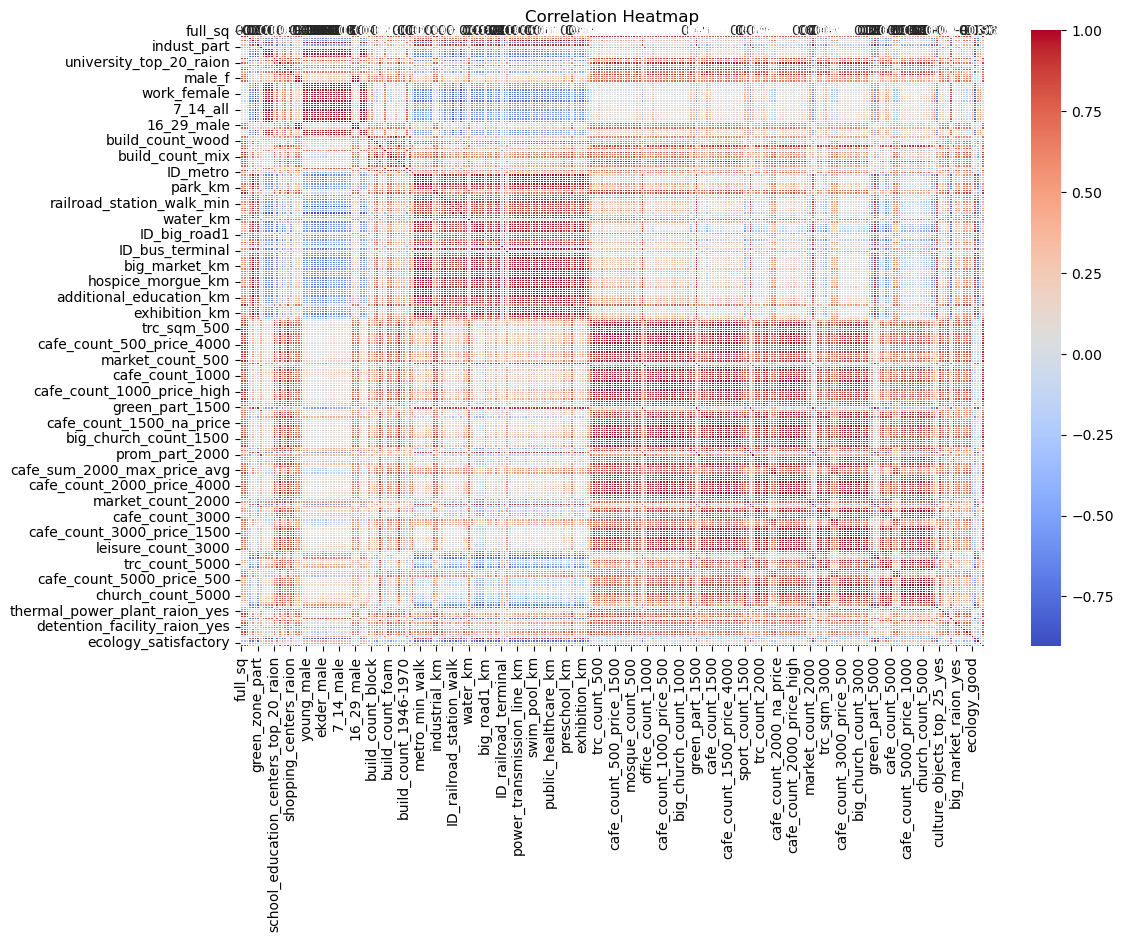

In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Load the training and test data
df_train_orig = pd.read_csv('train.csv')
df_test_orig = pd.read_csv('test.csv')

# Make a copy of the original data
df_train = df_train_orig.copy()
df_test = df_test_orig.copy()
target_col = 'price_doc'
row_id_col = 'row ID'

# Label encode the 'sub_area' column
label_encoder = LabelEncoder()
df_train['sub_area'] = label_encoder.fit_transform(df_train['sub_area'])
df_test['sub_area'] = label_encoder.transform(df_test['sub_area'])

# Create dummy variables for categorical features
X_train = pd.get_dummies(df_train.drop(columns=[target_col]), drop_first=True)
X_train_2 = X_train.copy()
X_test = pd.get_dummies(df_test, drop_first=True)

# Extract the target variable
y = df_train[target_col]

# Scale the values
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y, test_size=0.05, random_state=42)

# Calculate the correlation matrix
correlation_matrix = pd.DataFrame(np.corrcoef(np.column_stack((X_train, y_train)), rowvar=False), columns=X_train_2.columns.tolist() + [target_col])

# Create a heatmap of the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix.corr(), annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()


In [8]:
# Set a threshold for high correlation
threshold = 0.7  # Adjust this threshold as needed

# Create a mask for highly correlated features
highly_correlated = (correlation_matrix.corr().abs() > threshold)

# Create a list of columns to drop
columns_to_drop = [column for column in highly_correlated.columns if any(highly_correlated[column])]

# Drop the highly correlated columns from X_train_2
X_train_2_filtered = X_train_2.drop(columns=columns_to_drop)

# Display the columns that were removed
print("Columns removed due to high correlation:")
print(columns_to_drop)

# Create a heatmap of the correlation matrix for the filtered features
correlation_matrix_filtered = pd.DataFrame(np.corrcoef(np.column_stack((X_train_2_filtered, y_train)), rowvar=False), columns=X_train_2_filtered.columns.tolist() + [target_col])
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix_filtered.corr(), annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap (After Removing Highly Correlated Features)")
plt.show()



KeyError: "['price_doc'] not found in axis"